#### TODO:

~~Train&Test~~
- ~~split the dataset into train and test~~
- ~~drop the lables that are not working!~~

~~Inputs&Labels~~
- ~~mix the labels and input orders (all of them are [0,1])~~

Articles&Tenses
- Remove the articles and present tense verbs - Maunally :(

## Imports

In [10]:
import os
import requests
import pandas as pd
from PIL import Image
import io
import ast
import random
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from lambeq.backend.grammar import Ty, Box 
from lambeq import BobcatParser, AtomicType, Sim14Ansatz, RemoveCupsRewriter, Rewriter

import matplotlib.pyplot as plt
import numpy as np


print("(*) All libraries are successfully imported!\n")

(*) All libraries are successfully imported!



## Dataset

Split the dataset and label into trainign and testing similar to the pennyland model

In [11]:
# ==============================================
# ==============================================

# Specify the folder and file name
folder_name = "Features-Datasets"
file_name = "features_dataset_1.csv"

# Construct the file path
file_path = os.path.join(os.getcwd(), folder_name, file_name)


# Read the CSV file
# filename = "trial_feature_extraction.csv"   # Trained Bert X Resnet Epochs loop
# filename = "features_dataset.csv"         # Trained Resnet once
# file_path = os.path.join(os.getcwd(), filename)
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence']
image_1 = df['image_1']
image_2 = df['image_2']
label_image1 = df['label_image1']
label_image2 = df['label_image2']

df = pd.DataFrame({
    'sentence': sentence,
    'image_1': image_1,
    'image_2': image_2,
    'label_image1': label_image1,
    'label_image2': label_image2
})

# Make the image_1 and image_2 into float lists instead of strings
df["image_1"] = df["image_1"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["image_2"] = df["image_2"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# ============= TODO: =============
# RE ORDER THE LABELS AND IMAGES!

print(f" Length of dataframe: {len(df)}")

n = random.randint(80, 120) # Number of indicies to swap
print( " Amount of indicies to swap: ", n)

index_to_swap = random.sample(range(0, len(df) + 1), n)
# print(f" Random Indicies to swap: \n{index_to_swap}")

for index, row in df.iterrows():
    if index in index_to_swap:
        # print(f" Index {index}: swapping")
        # Swap imags and labels
        df.at[index, 'image_1'], df.at[index, 'image_2'] = df.at[index, 'image_2'], df.at[index, 'image_1']
        df.at[index, 'label_image1'], df.at[index, 'label_image2'] = df.at[index, 'label_image2'], df.at[index, 'label_image1']

print("(*) Completed swapping the values of random n labels. \n")

# =================================

# First split: train and combined validation/test set
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Second split: validation and test set
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print the sizes of each set to verify
print(f" Training set size: {len(train_df)}")
print(f" Validation set size: {len(val_df)}")
print(f" Test set size: {len(test_df)}")


print("(*) Data Extracted!\n")

 Length of dataframe: 376
 Amount of indicies to swap:  109
(*) Completed swapping the values of random n labels. 

 Training set size: 263
 Validation set size: 56
 Test set size: 57
(*) Data Extracted!



## Sentences Diagram & Circuit

 parsing sentences ..
.
 ↓ example senetnce diagram from raw train dataset, index : 3


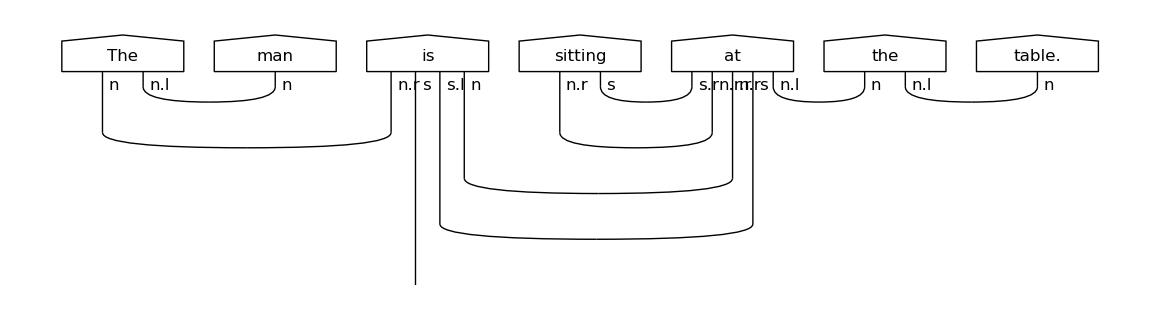

 rewritting the article grammar sentences ..
 ↓ example senetnce diagram from rewritten train dataset, index : 3


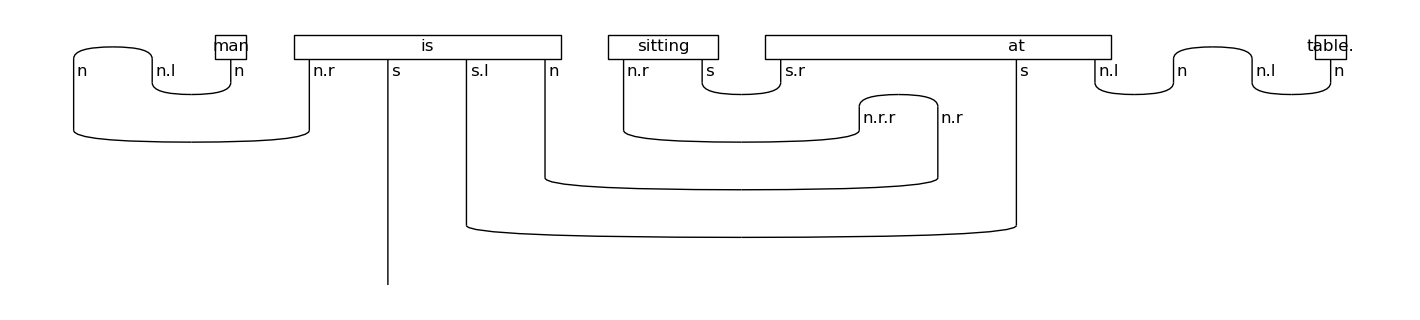

 removing cups from rewritten diagrams ..
 ↓ sample sentence diagram without cups from rewritten train datase, index : 3


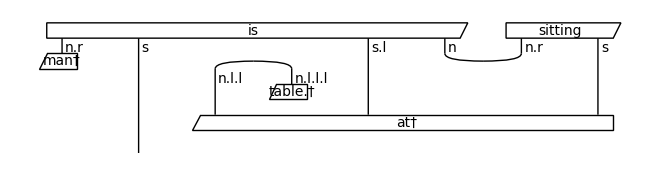

 ↓ sample sentence circuit from train dataset, index : 3


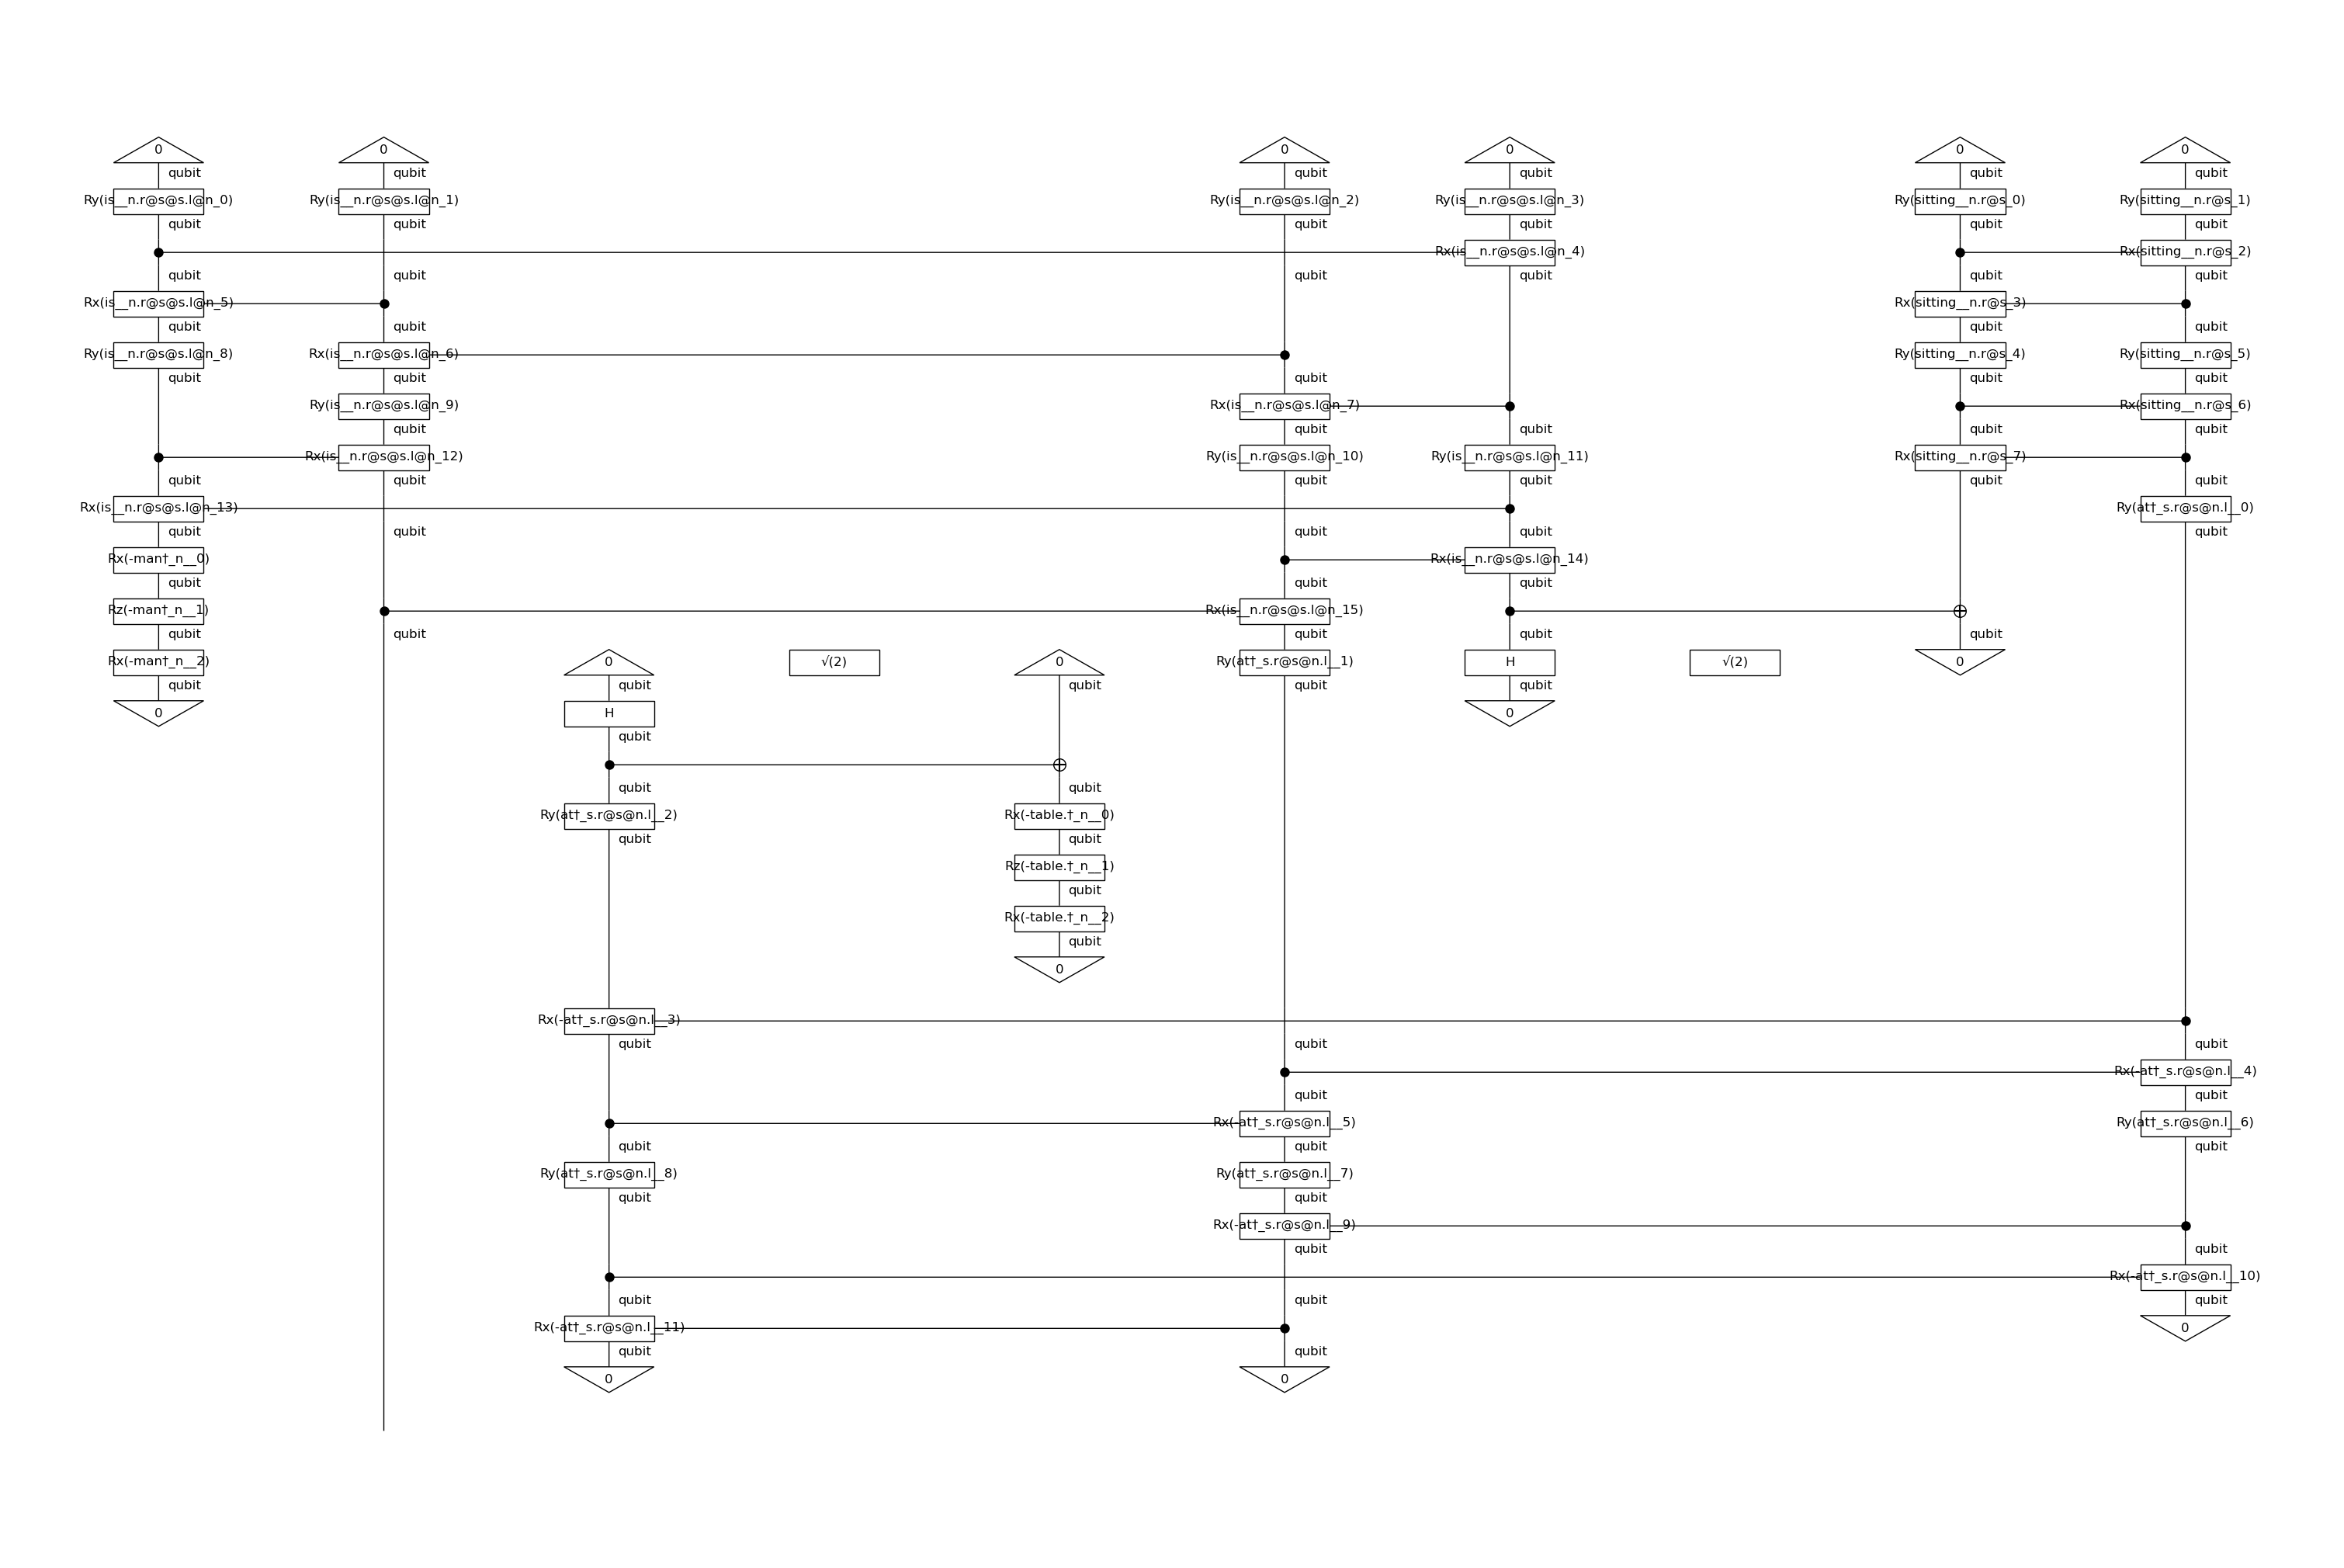

(*) Ansatz created for all senetnces!



In [12]:
# ==============================================
# CREATE SENTENCE DIAGRAMS WITH REWRITER
# ==============================================
# Index to show the sample words
sample_index = 3

remove_cups = RemoveCupsRewriter()
rewriter = Rewriter(['prepositional_phrase', 'determiner'])

# Parse the sentence 
train_sentences = train_df["sentence"]
val_sentences = val_df["sentence"]
test_sentences = test_df["sentence"]

# Use BobbcatParser to convert it into a string diagram
print(" parsing sentences ..")
parser = BobcatParser(verbose='suppress')
print(".")
raw_train_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in train_sentences]
raw_val_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in val_sentences]
raw_test_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in test_sentences]
# --------
print(f" ↓ example senetnce diagram from raw train dataset, index : {sample_index}")
raw_train_sentence_diagrams[sample_index].draw(figsize=(14, 3), fontsize=12)
# --------

# Use the rewriter function to remove any prepositionla and determinators
print(" rewritting the article grammar sentences ..")
rewritten_train_sentence_diagrams = [rewriter(diag) for diag in raw_train_sentence_diagrams]
rewritten_val_sentence_diagrams = [rewriter(diag) for diag in raw_val_sentence_diagrams]
rewritten_test_sentence_diagrams = [rewriter(diag) for diag in raw_test_sentence_diagrams]
# --------
print(f" ↓ example senetnce diagram from rewritten train dataset, index : {sample_index}")
rewritten_train_sentence_diagrams[sample_index].draw(figsize=(14, 3), fontsize=12)
# --------

# Use remove cups to decrease the number of wires used
print(" removing cups from rewritten diagrams ..")
train_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in rewritten_train_sentence_diagrams]
val_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in rewritten_val_sentence_diagrams]
test_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in rewritten_test_sentence_diagrams]
# --------
print(f' ↓ sample sentence diagram without cups from rewritten train datase, index : {sample_index}')
train_diagrams_sentence[sample_index].draw()
# --------

ansatz_sentence = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1},n_layers=3)

train_circuits_sentence = [ansatz_sentence(diagram) for diagram in train_diagrams_sentence]
val_circuits_sentence = [ansatz_sentence(diagram) for diagram in val_diagrams_sentence]
test_circuits_sentence = [ansatz_sentence(diagram) for diagram in test_diagrams_sentence]
# --------
print(f' ↓ sample sentence circuit from train dataset, index : {sample_index}')
train_circuits_sentence[sample_index].draw(figsize=(30, 20), fontsize=12)
# --------

print("(*) Ansatz created for all senetnces!\n")

## Image Diagram & Circuit

↓ template image box


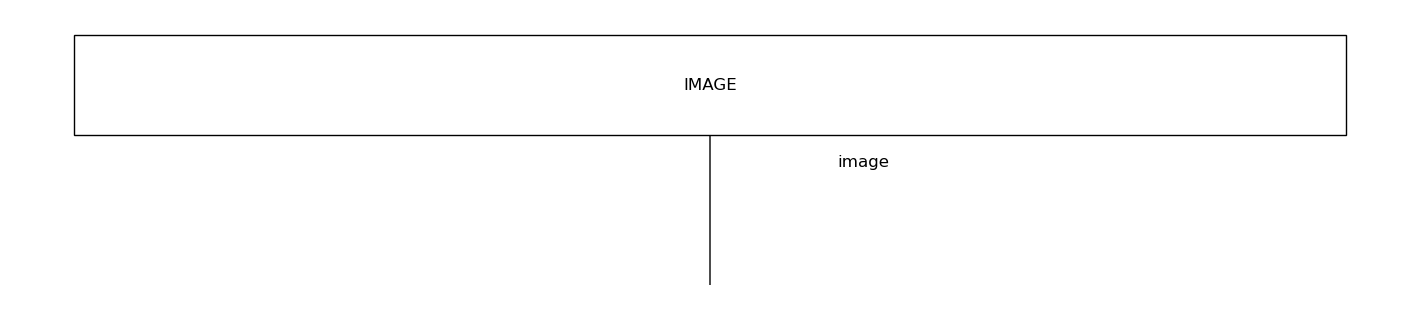

↓ template image circuit


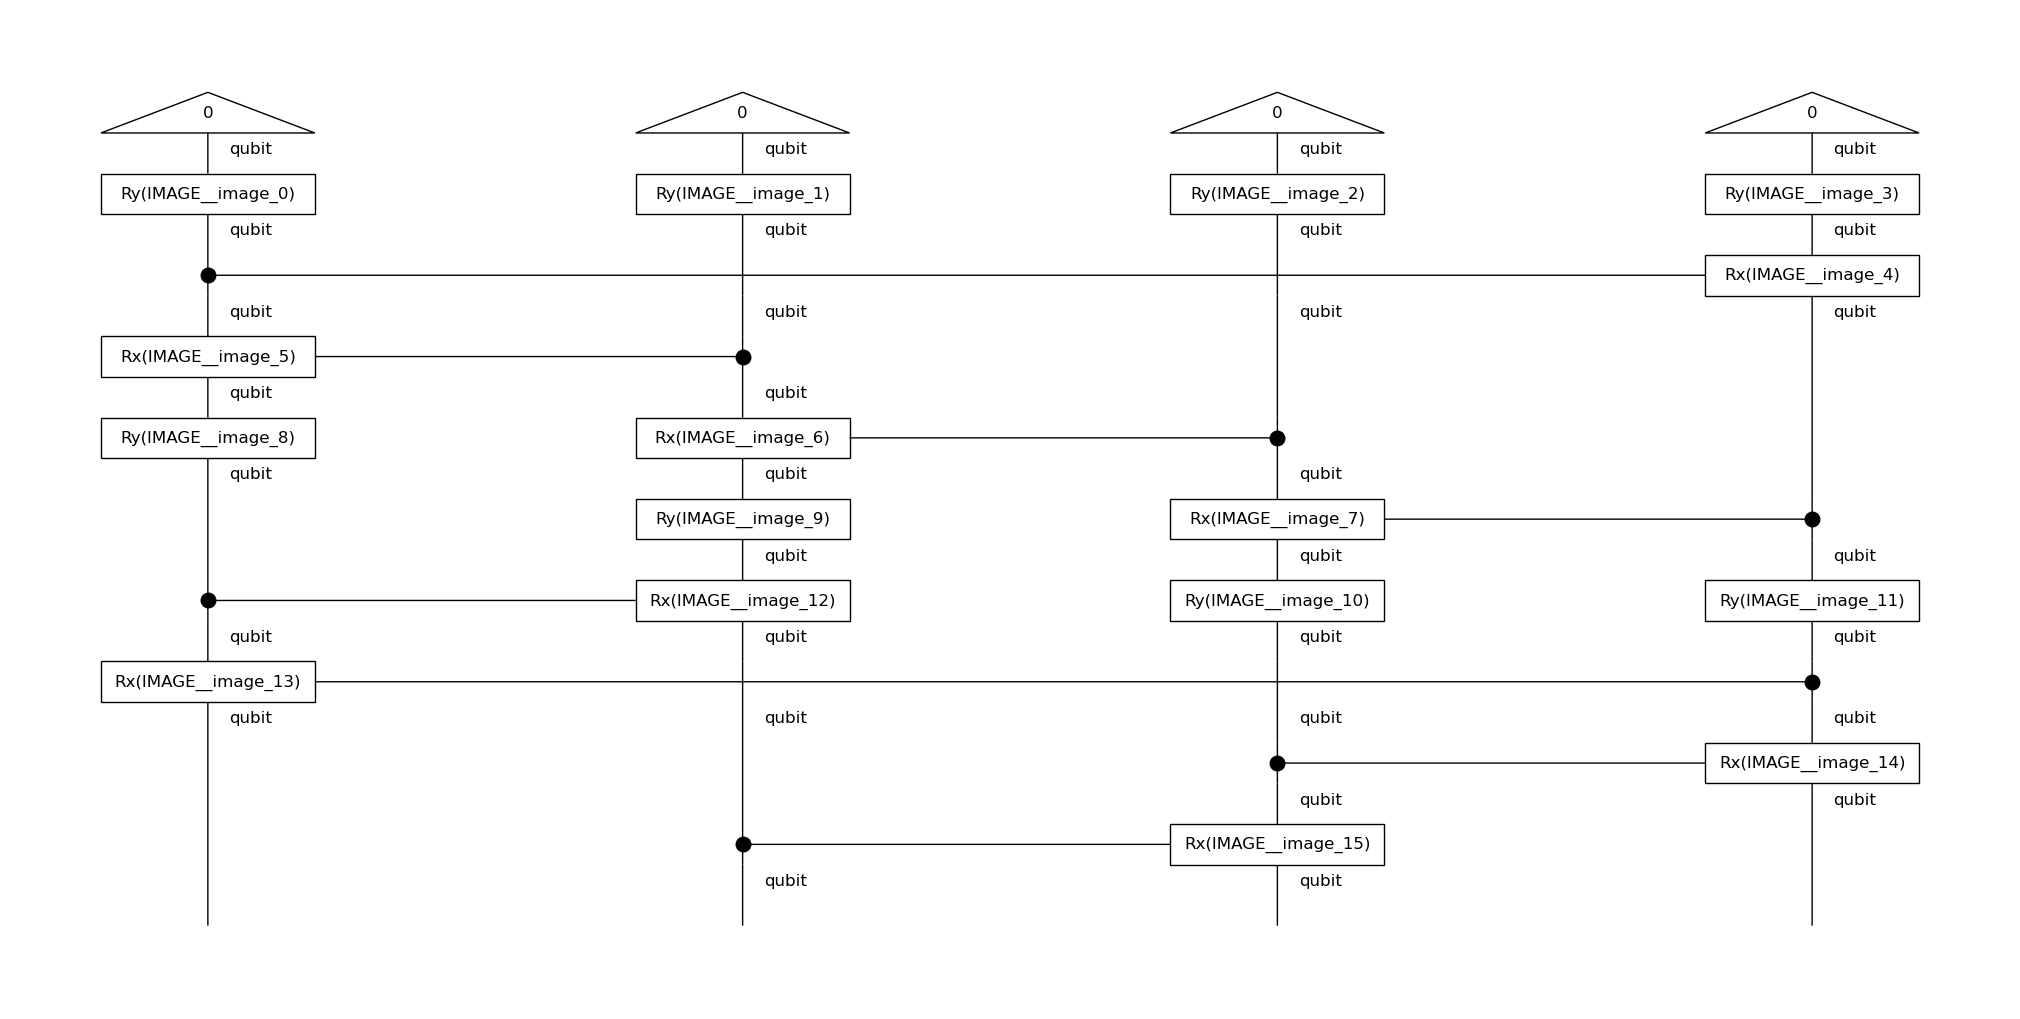

 Complete: circuits for positive image
 ↓ sample sentence diagram without cups from train dataset


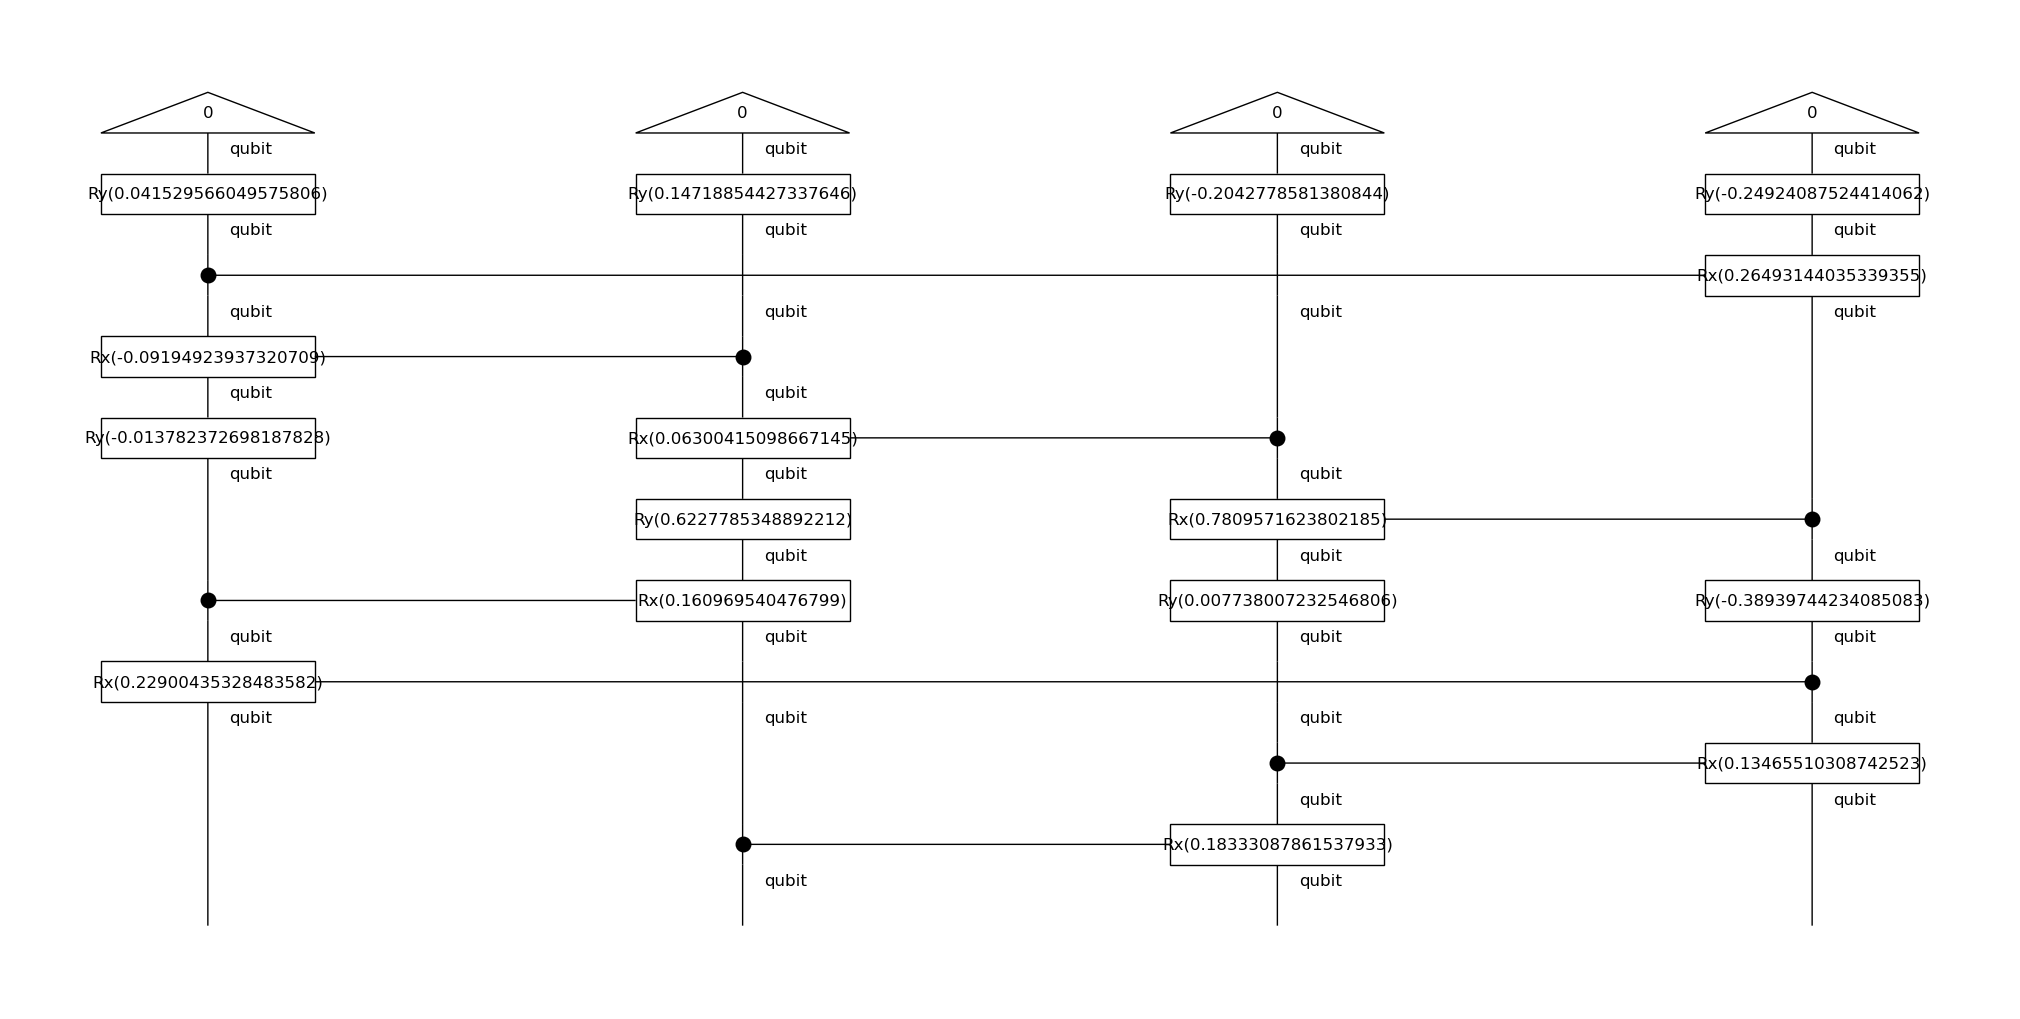

 Complete: circuit for negative images


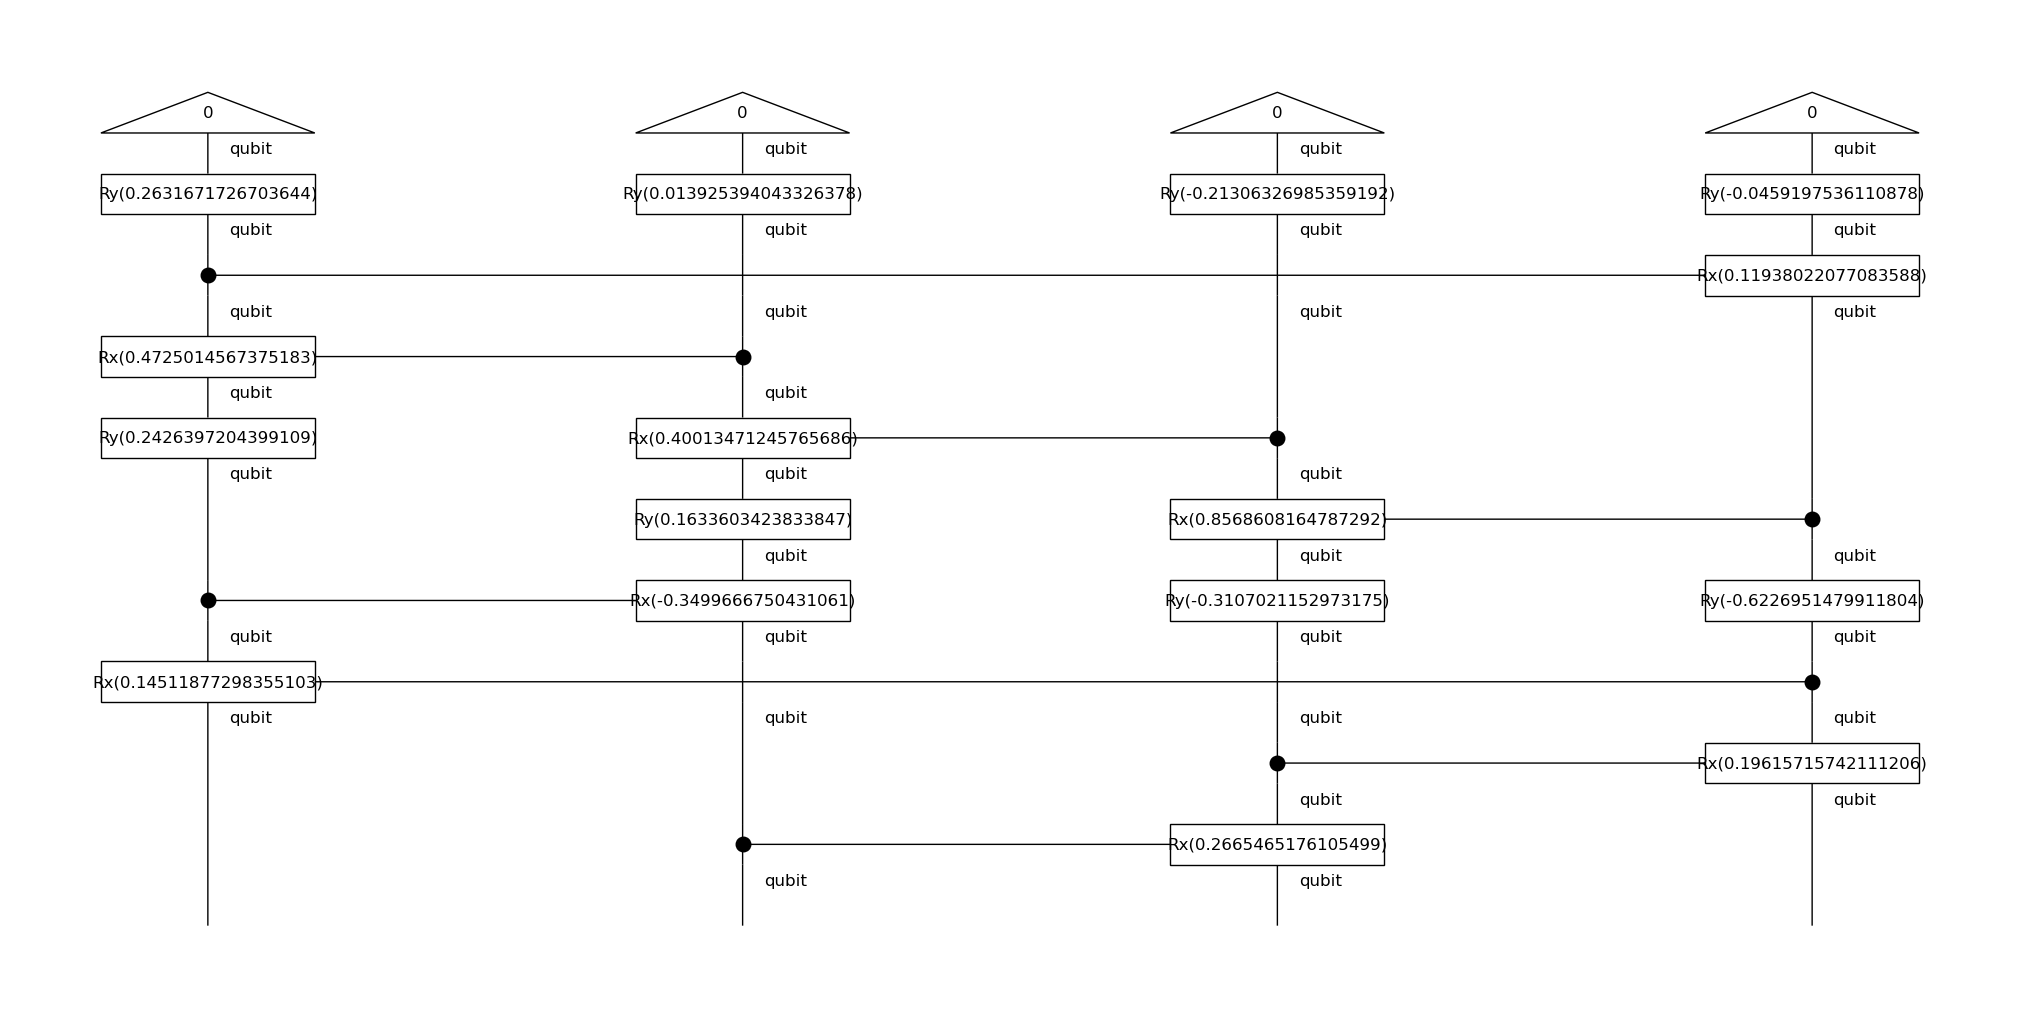

(*) Circuits and digrams created for all images!



In [13]:
# Create a new image Ty
image_type = Ty("image")
image_box = Box(name = "IMAGE", dom = Ty(), cod= image_type)
print('↓ template image box')
image_box.draw(figsize=(14, 3), fontsize=12)

# Create template Ansatz
ansatz = Sim14Ansatz({image_type: 4}, n_layers=3)
image_circ = ansatz(image_box)
print('↓ template image circuit')
image_circ.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit POSITIVE
train_images_1 = train_df["image_1"]
val_images_1 = val_df["image_1"]
test_images_1 = test_df["image_1"]

train_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in train_images_1]
val_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in val_images_1]
test_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in test_images_1]
print(" Complete: circuits for positive image")
#  --------
print(' ↓ sample sentence diagram without cups from train dataset')
train_circuits_image1[sample_index].draw(figsize=(20, 10), fontsize=12)
#  --------

# Add data into image circuit NEGATIVE
train_images_2 = train_df["image_2"]
val_images_2 = val_df["image_2"]
test_images_2 = test_df["image_2"]

train_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in train_images_2]
val_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in val_images_2]
test_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in test_images_2]
print(" Complete: circuit for negative images")
#  --------
train_circuits_image2[sample_index].draw(figsize=(20, 10), fontsize=12)
#  --------

print("(*) Circuits and digrams created for all images!\n")

## Combined for Sentence & Images:

WARNING:
- ONLY RUN THIS CODE ONCE!

#### Diagram template 

************************
Dropped the following indicies: [6, 13, 15, 22, 33, 34, 39, 47, 58, 61, 72, 89, 137, 145, 148, 155, 162, 167, 178, 181, 199, 206, 214, 217, 228, 242, 257]
************************
Dropped the following indicies: [10, 20, 21, 29, 41, 50, 54]
************************
Dropped the following indicies: [3, 21, 22, 27, 28, 40, 42, 45, 50, 54]
CHCEKING:
    124 -> 236 == 236
    29 -> 49 == 49
    31 -> 47 == 47
 ↓ template merged diagram : (sentence, image1, image2)


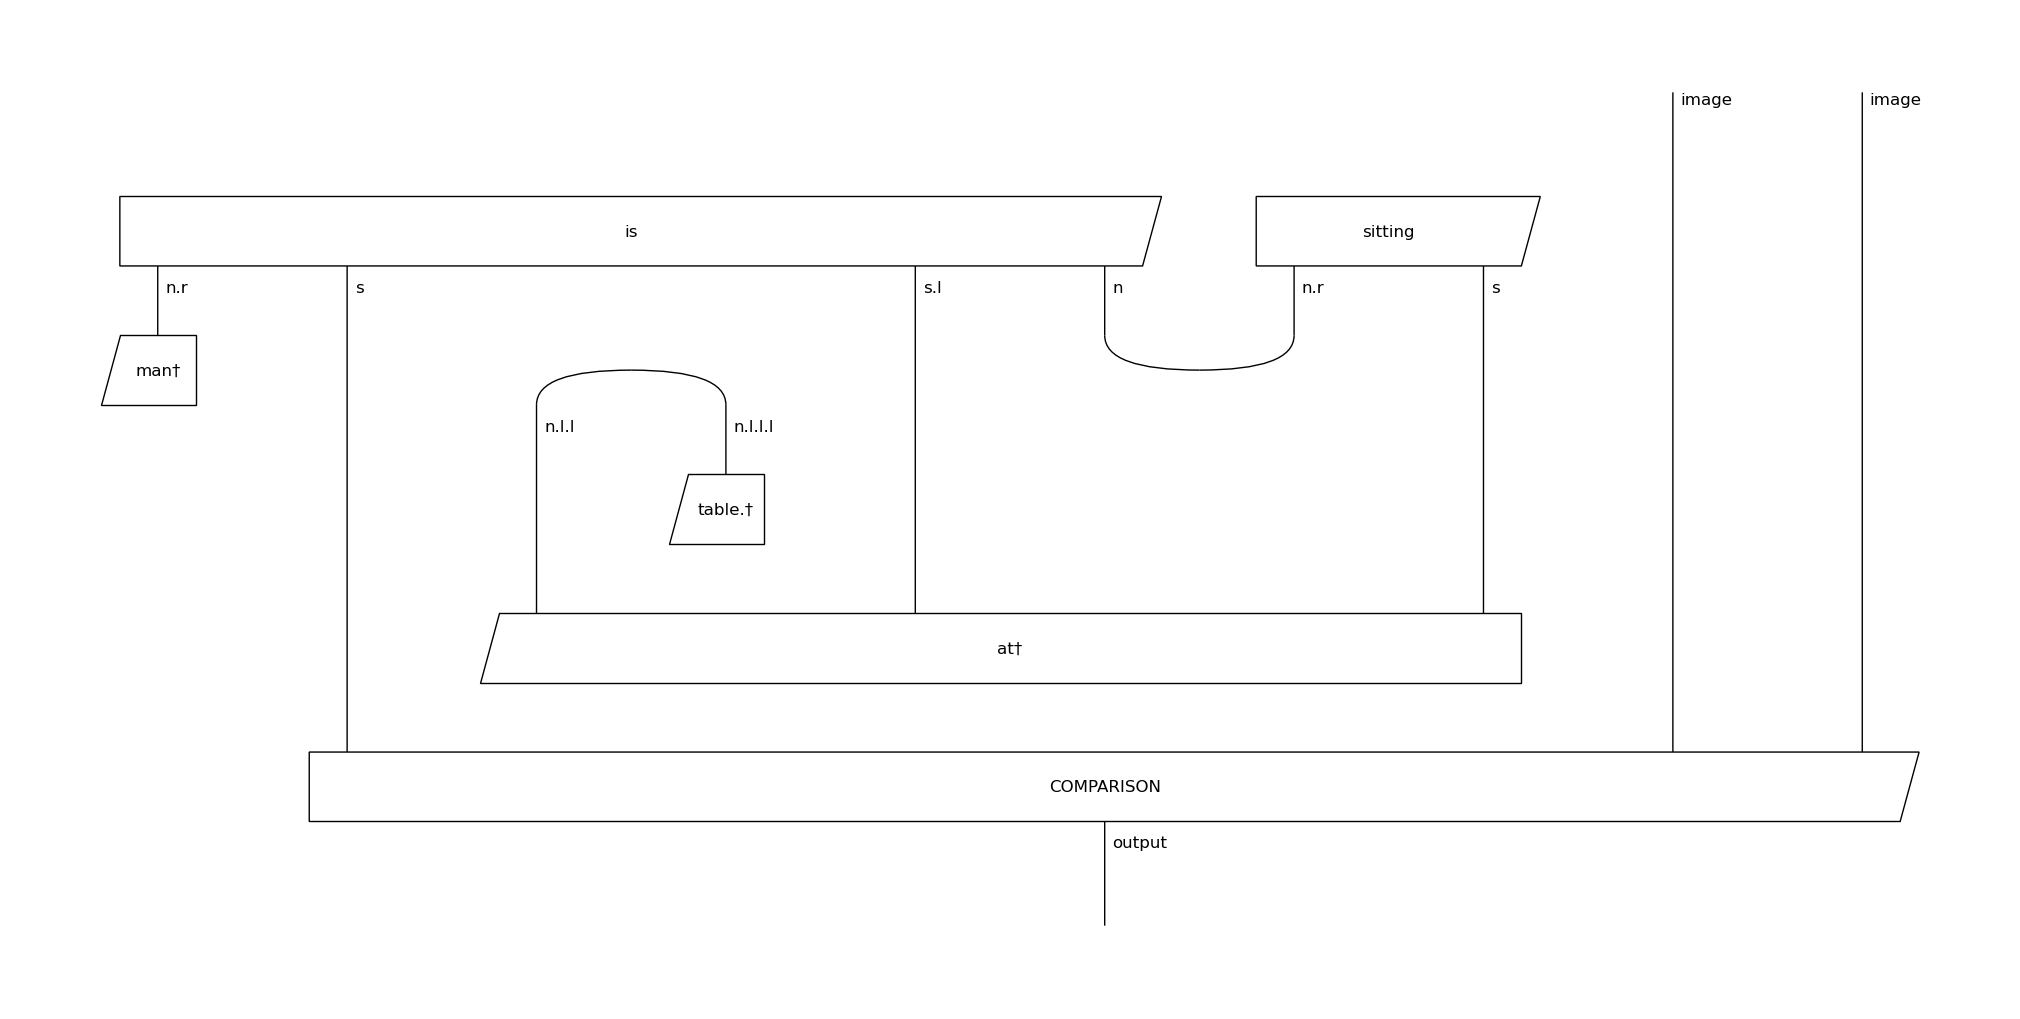



(*) Train: 236 diagrams completed successfully!
(*) Val: 49 diagrams completed successfully!
(*) Test: 47 diagrams completed successfully!


In [14]:
# CREATE FINAL CIRCUIT

def generate_valid_diagrams(diagram_sentence, df):
    print("************************")
    indicies_to_drop= []
    conc_diagrams = []
    for index, row in df.iterrows():
        try:
            temp = diagram_sentence[index] @ image_type @ image_type >> comparison_box
            conc_diagrams.append(temp)
        except Exception as e:
            # print(f"Error at index in diagram sentence {index}: {e}")
            # print( "    ",df["sentence"].iloc[index])
            indicies_to_drop.append(index)
    # print("************************")

    # print("************************")
    for index, row in df.iterrows():
        if index in indicies_to_drop:
            # print("Removing index: ", index)
            df = df.drop(index = index)
    # print("************************")

    print("Dropped the following indicies:", indicies_to_drop)
    
    return df, conc_diagrams

# Create new Type
output_type = Ty("output")
comparison_box = Box("COMPARISON", AtomicType.SENTENCE @ image_type @ image_type, output_type)

# Draws diagram with comparison box (0,1) - Sentence digram and comparison box is in grammar form

train_df, train_conc_diagrams = generate_valid_diagrams(train_diagrams_sentence, train_df)
val_df, val_conc_diagrams = generate_valid_diagrams(val_diagrams_sentence, val_df)
test_df, test_conc_diagrams = generate_valid_diagrams(test_diagrams_sentence, test_df)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("CHCEKING:")
print(f"    124 -> {len(train_df)} == {len(train_conc_diagrams)}")
print(f"    29 -> {len(val_df)} == {len(val_conc_diagrams)}")
print(f"    31 -> {len(test_df)} == {len(test_conc_diagrams)}")

print(' ↓ template merged diagram : (sentence, image1, image2)')
train_conc_diagrams[sample_index].draw(figsize=(20, 10), fontsize=12)

print("")
print(f"\n(*) Train: {len(train_conc_diagrams)} diagrams completed successfully!")
print(f"(*) Val: {len(val_conc_diagrams)} diagrams completed successfully!")
print(f"(*) Test: {len(test_conc_diagrams)} diagrams completed successfully!")

#### Circuit Template

************************
Error at index in diagram sentence 2: Ty(p)
Error at index in diagram sentence 68: Ty(p)
Error at index in diagram sentence 75: Ty(p)
Error at index in diagram sentence 110: Ty(p)
Error at index in diagram sentence 117: Ty(p)
Error at index in diagram sentence 142: Ty(p)
Error at index in diagram sentence 147: Ty(p)
Error at index in diagram sentence 215: Ty(p)
Error at index in diagram sentence 220: Ty(p)
Dropped the following indicies: [2, 68, 75, 110, 117, 142, 147, 215, 220]
************************
Error at index in diagram sentence 1: Ty(p)
Error at index in diagram sentence 14: Ty(p)
Error at index in diagram sentence 19: Ty(p)
Error at index in diagram sentence 28: Ty(p)
Error at index in diagram sentence 30: Ty(p)
Error at index in diagram sentence 32: Ty(p)
Dropped the following indicies: [1, 14, 19, 28, 30, 32]
************************
Dropped the following indicies: []
CHCEKING:
  (118) 227 == 227
  (27)  43 == 43
  (30)  47 == 47
 ↓ template merged

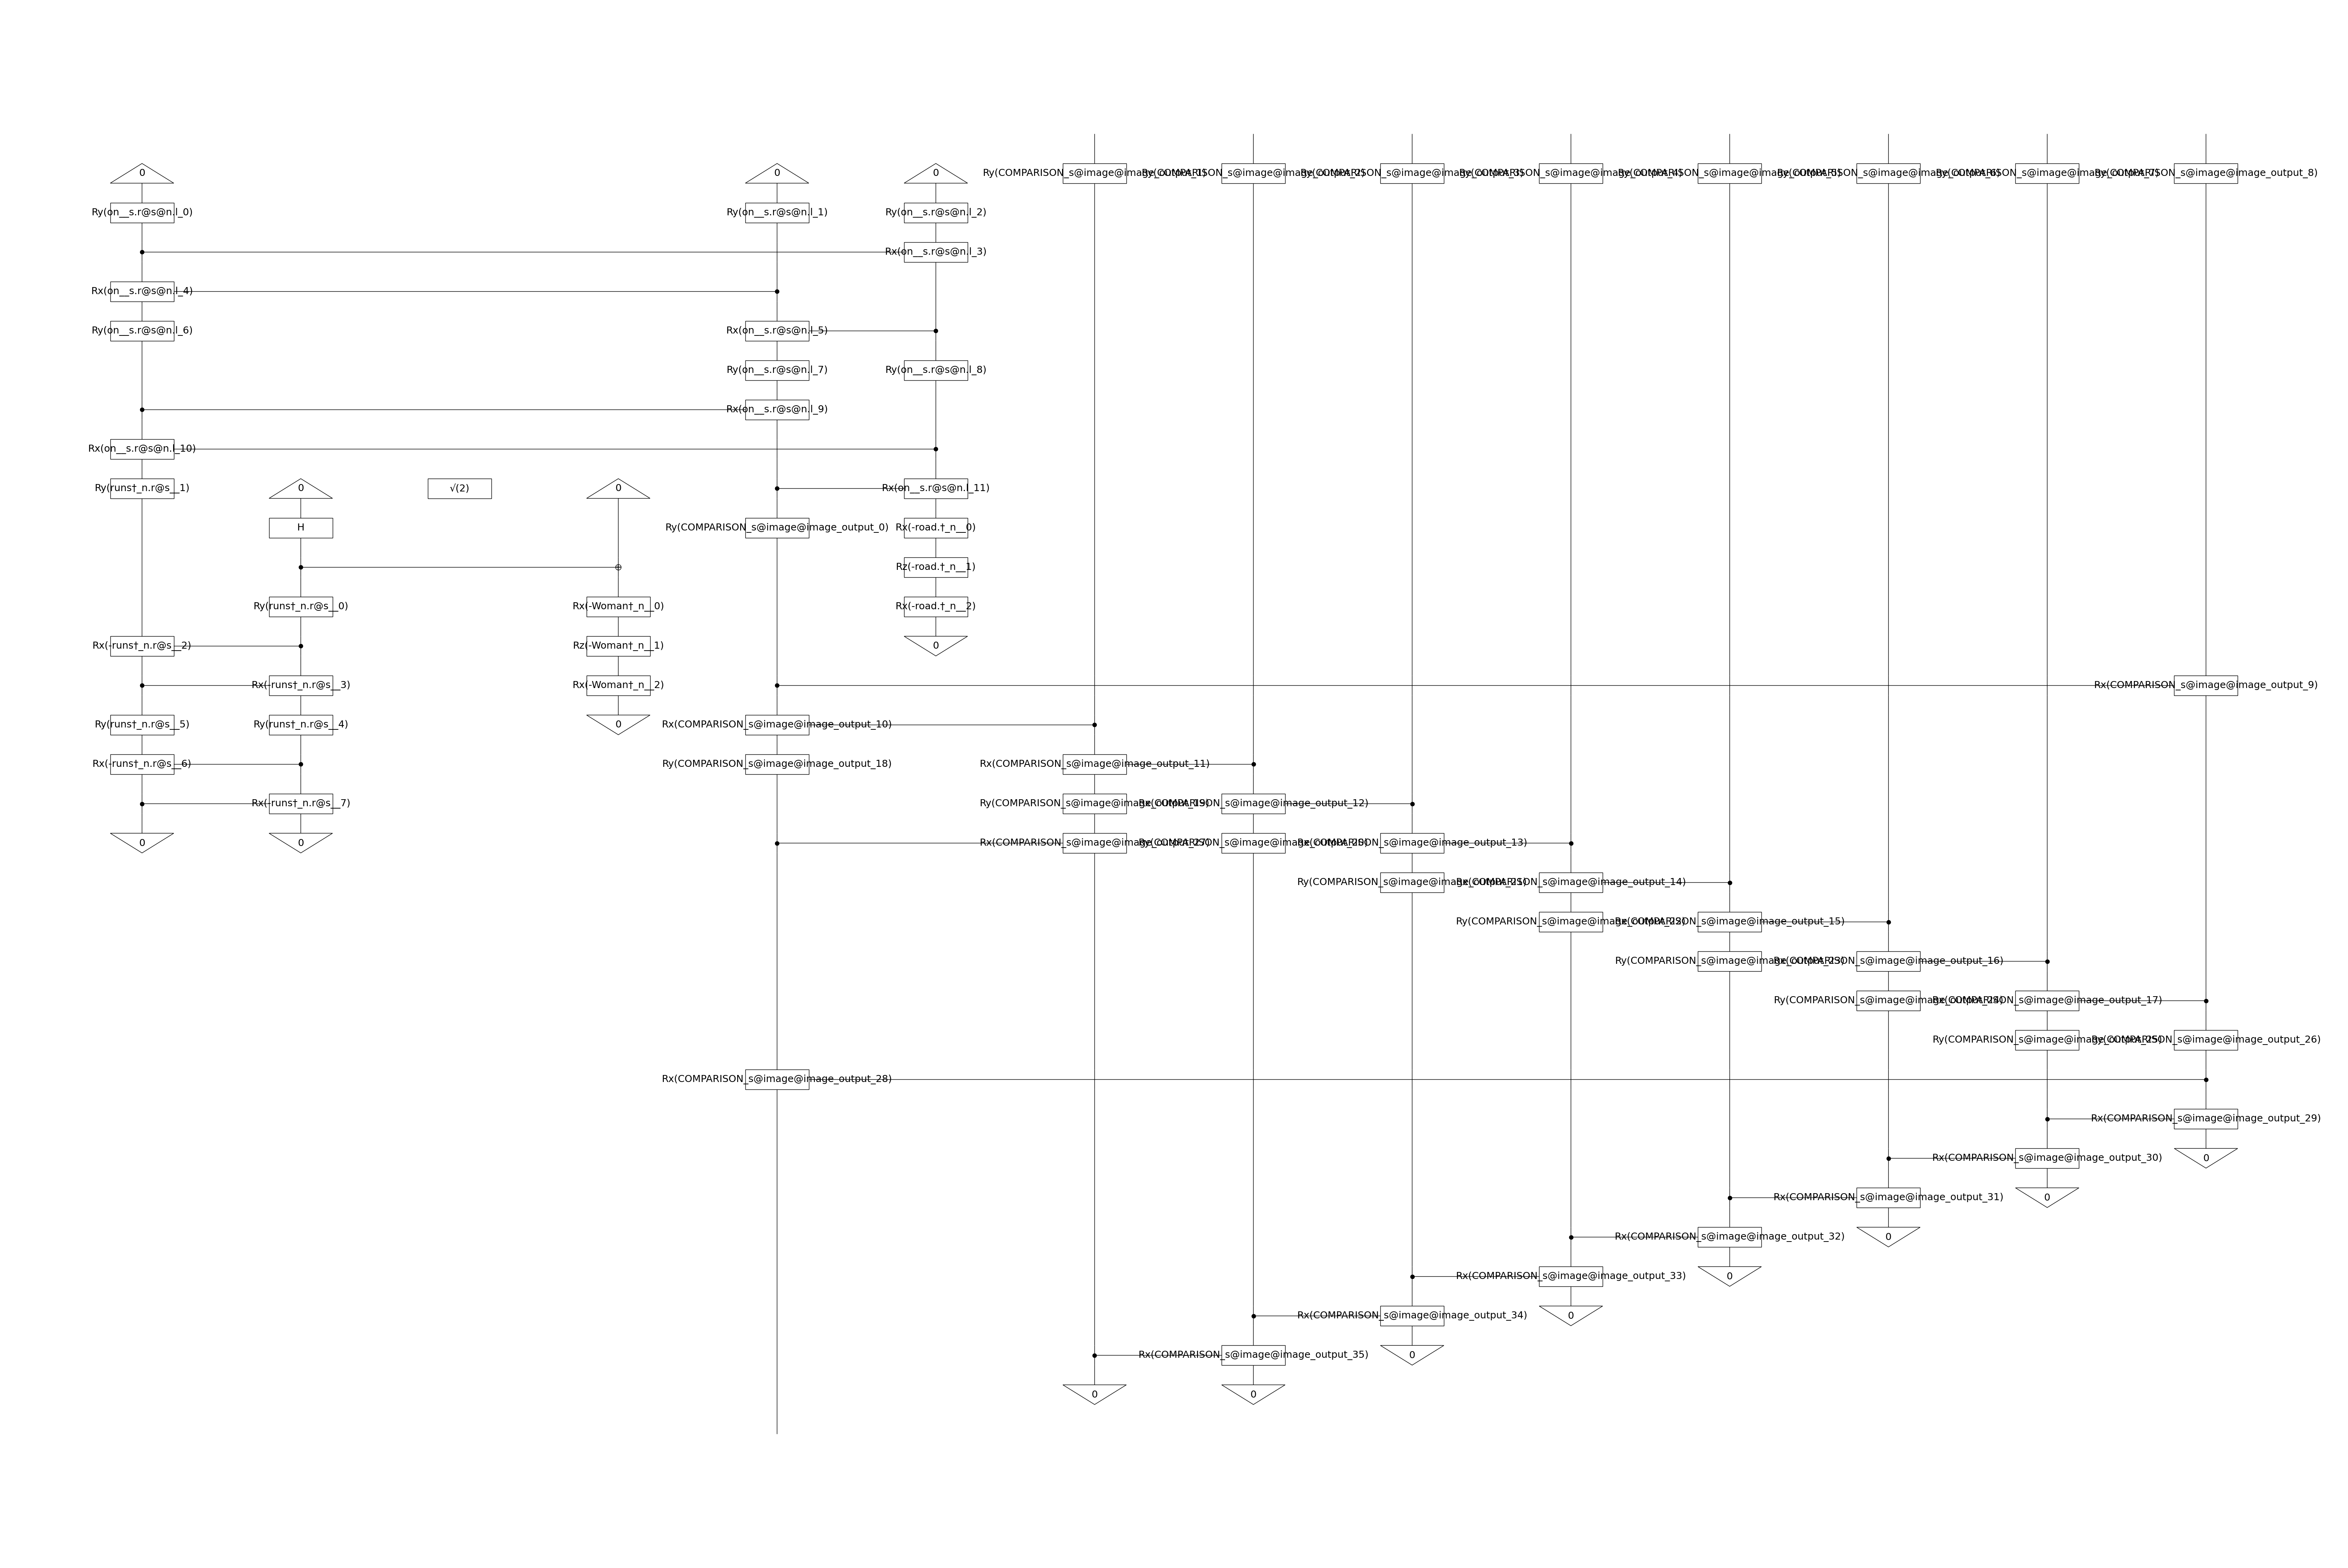



(*) Train: 227 circuits completed successfully!
(*) Val: 43 circuits completed successfully!
(*) Test: 47 circuits completed successfully!


In [15]:
# Ansatz & Circuit
ansatz = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, image_type : 4, output_type : 1},  n_layers=3)

# Incorrect prepositional phrases found in the diagrams
def generate_valid_circuits(conc_diagrams, df):
    print("************************")
    indicies_to_drop = []
    conc_circuit = []
    for index, row in df.iterrows():
        try:
            temp = ansatz(conc_diagrams[index])
            conc_circuit.append(temp)
        except Exception as e:
            print(f"Error at index in diagram sentence {index}: {e}")
            # print( "    ",df["sentence"].iloc[index])
            indicies_to_drop.append(index)
    # print("************************")

    # print("************************")
    for index, row in df.iterrows():
        if index in indicies_to_drop:
            # print("Removing index: ", index)
            df = df.drop(index = index)
    # print("************************")

    print("Dropped the following indicies:", indicies_to_drop)
    
    return df, conc_circuit

train_df, train_conc_circuits = generate_valid_circuits(train_conc_diagrams, train_df)
val_df, val_conc_circuits = generate_valid_circuits(val_conc_diagrams, val_df)
test_df, test_conc_circuits = generate_valid_circuits(test_conc_diagrams, test_df)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("CHCEKING:")
print(f"  (118) {len(train_df)} == {len(train_conc_circuits)}")
print(f"  (27)  {len(val_df)} == {len(val_conc_circuits)}")
print(f"  (30)  {len(test_df)} == {len(test_conc_circuits)}")

print(' ↓ template merged circuit : (sentence, image1, image2)')
train_conc_circuits[sample_index].draw(figsize=(60, 40), fontsize=18, draw_type_labels = False )

print("")
print(f"\n(*) Train: {len(train_conc_circuits)} circuits completed successfully!")
print(f"(*) Val: {len(val_conc_circuits)} circuits completed successfully!")
print(f"(*) Test: {len(test_conc_circuits)} circuits completed successfully!")


#### Final Circuit 

  ↓ sample quantum circuit : (sentence, image data pos , image data neg)


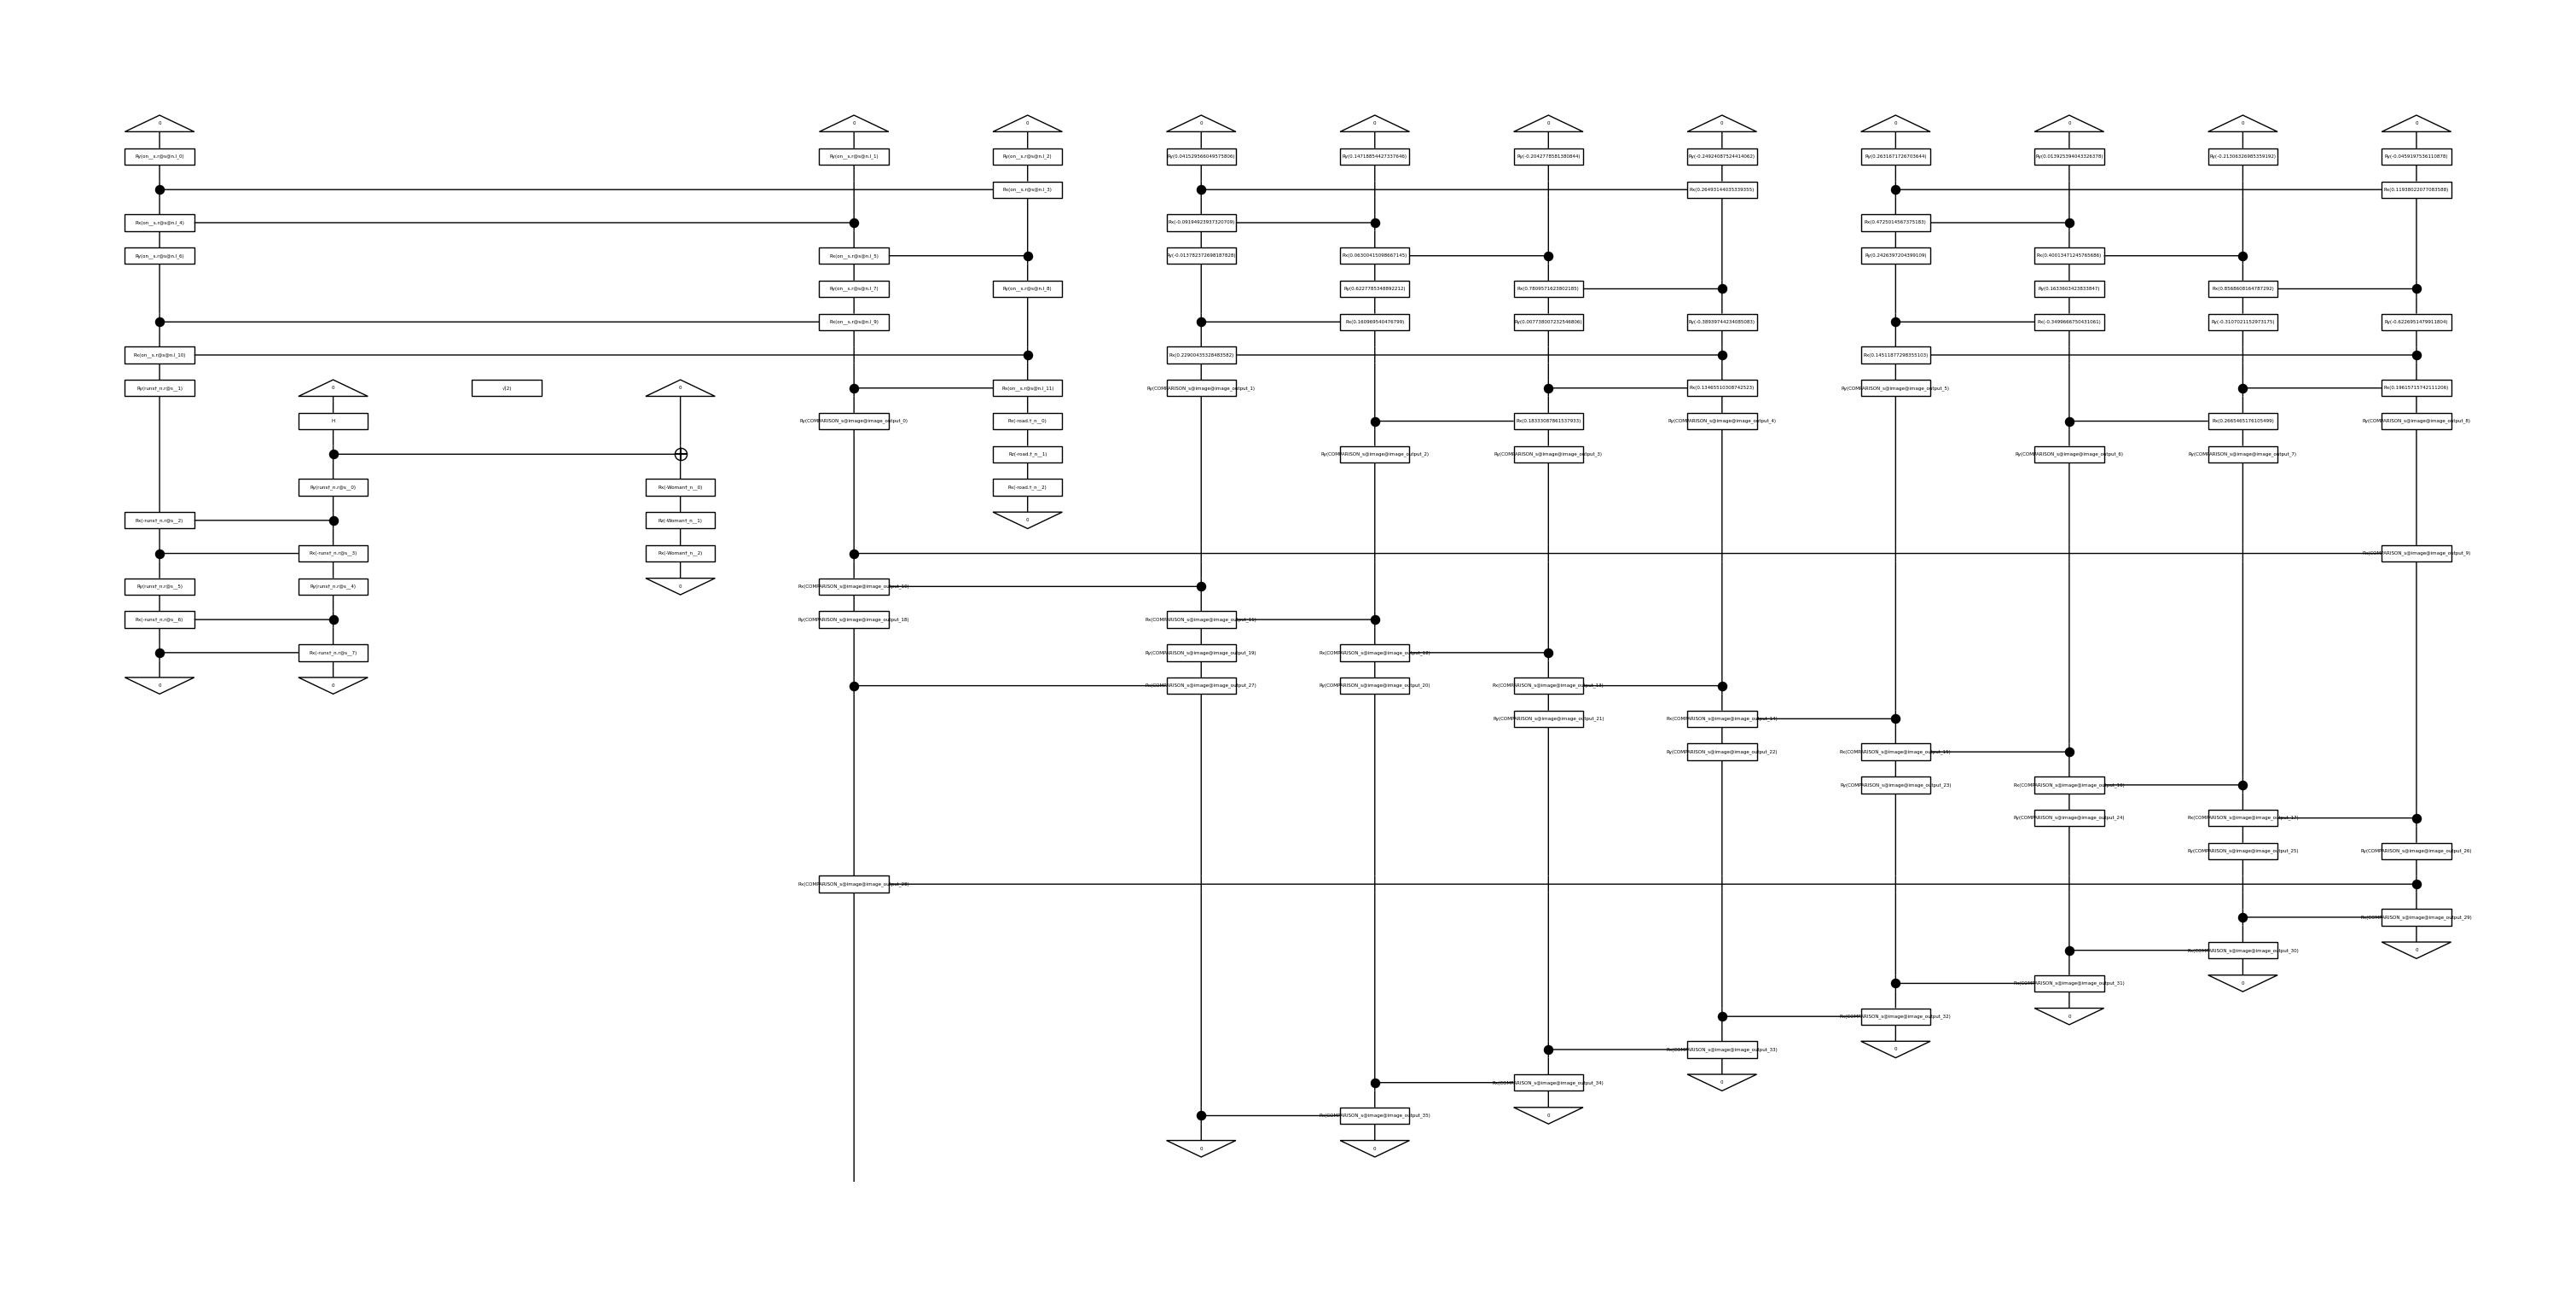


(*) Train: 227 circuits completed successfully!
(*) Val:43 circuits completed successfully!
(*) Test: 47 circuits completed successfully!


In [16]:
# final_circuit = image_1 @ image_2 >> temp_circuit

train_final_circuit = [(train_circuits_image1[index] @ train_circuits_image2[index] >> train_conc_circuits[index]) for index in range(len(train_df))]
val_final_circuit = [(val_circuits_image1[index] @ val_circuits_image2[index] >> val_conc_circuits[index]) for index in range(len(val_df))]
test_final_circuit = [(test_circuits_image1[index] @ test_circuits_image2[index] >> test_conc_circuits[index]) for index in range(len(test_df))]

print("  ↓ sample quantum circuit : (sentence, image data pos , image data neg)")
train_final_circuit[sample_index].draw(figsize=(30, 15), fontsize=4, draw_type_labels = False )

print(f"\n(*) Train: {len(train_final_circuit)} circuits completed successfully!")
print(f"(*) Val:{len(val_final_circuit)} circuits completed successfully!")
print(f"(*) Test: {len(test_final_circuit)} circuits completed successfully!")


adding a labels row

-> SHOUDL MOVE THIS TO DATASET SECTION

In [17]:
train_df['labels'] = train_df.apply(lambda row: (row['label_image1'], row['label_image2']), axis=1)
val_df['labels'] = val_df.apply(lambda row: (row['label_image1'], row['label_image2']), axis=1)
test_df['labels'] = test_df.apply(lambda row: (row['label_image1'], row['label_image2']), axis=1)


## Training on Quantum Circuit

this is taken from [7] onwords https://cqcl.github.io/lambeq/examples/quantum-pipeline-jax.html 

In [36]:
# Create a model 
from lambeq import NumpyModel
from lambeq import BinaryCrossEntropyLoss
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset
from sklearn.metrics import f1_score, precision_score, recall_score
import jax

print("Functions")
# Accuracy function contains double counting? 
def accuracy(y_hat, y):
    return np.sum(np.round(y_hat) == y) / len(y) / 2

# Precision function
def precision(y_hat, y):
    y_hat_rounded = np.round(y_hat)
    return precision_score(y, y_hat_rounded, average='weighted') / 2 

# Recall function
def recall(y_hat, y):
    y_hat_rounded = np.round(y_hat)
    return recall_score(y, y_hat_rounded, average='weighted') / 2

# F1 score function
def f1(y_hat, y):
    y_hat_rounded = np.round(y_hat)
    return f1_score(y, y_hat_rounded, average='weighted') / 2

print("Variables")
BATCH_SIZE = 20
LEARNING_RATE = 3e-2
EPOCHS = 250
SEED = 0

print("Definitions")
# Labels
train_labels = np.array([[label] for label in train_df['labels']]).squeeze(axis=1)
val_labels = np.array([[label] for label in val_df['labels']]).squeeze(axis=1)
test_labels = np.array([[label] for label in test_df['labels']]).squeeze(axis=1)

# Circuits
all_circuits = train_final_circuit + val_final_circuit + test_final_circuit

print("Model")
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
bce = BinaryCrossEntropyLoss(use_jax=True)

print("Initialize the trainer")
trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    # optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    optim_hyperparams = {'a': 0.02, 'c': 0.06, 'A': 0.001 * EPOCHS},
    evaluate_functions={'acc': accuracy, 'f1': f1, 'precision': precision, 'recall': recall},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0,
)

# a : step size in the parameter space during each update
# c : size of the perturbations used to approximate the gradient
# A : affects the decay of the learning rate over time

print("Dataset")
train_dataset = Dataset(train_final_circuit, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(val_final_circuit, val_labels, shuffle=False)

Functions
Variables
Definitions
Model
Initialize the trainer
Dataset


**RE-RUN EVERTHING FROM HERE ON**

In [37]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the checkpoint callback
# checkpoint_cb = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# # Fit the model
# trainer.fit(train_dataset, val_dataset, callbacks=[checkpoint_cb], log_interval=10)

trainer.fit(train_dataset, val_dataset, log_interval=20)
# best_model = tf.keras.models.load_model('best_model.h5')

/Users/halahawashin/anaconda3/envs/comp0197-pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/halahawashin/anaconda3/envs/comp0197-pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 20:   train/loss: 0.3483   valid/loss: 0.8769   train/acc: 0.5330   train/f1: 0.2743   train/precision: 0.3115   train/recall: 0.2665   valid/acc: 0.6047   valid/f1: 0.3174   valid/precision: 0.3565   valid/recall: 0.3023
/Users/halahawashin/anaconda3/envs/comp0197-pt/lib/python3.11/site-packages/sklear

Training Metrics

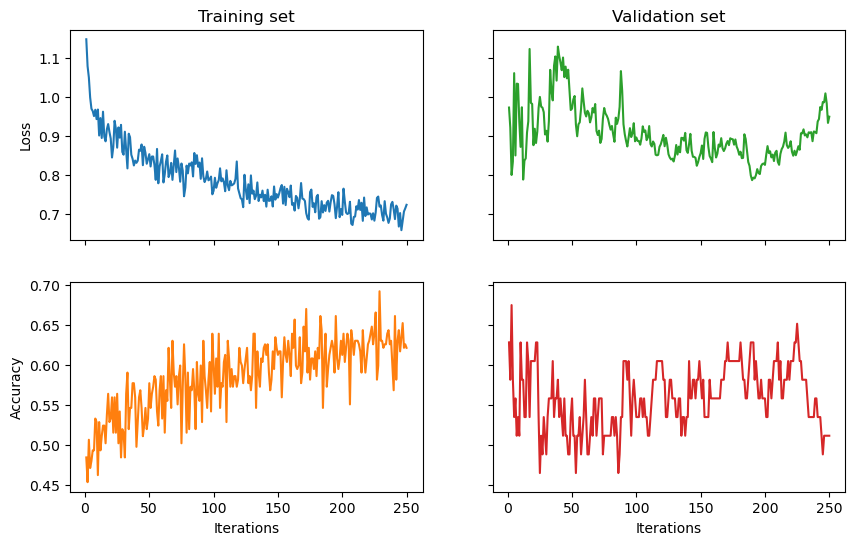

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Validation set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

This section is providing inaccurate metrics!


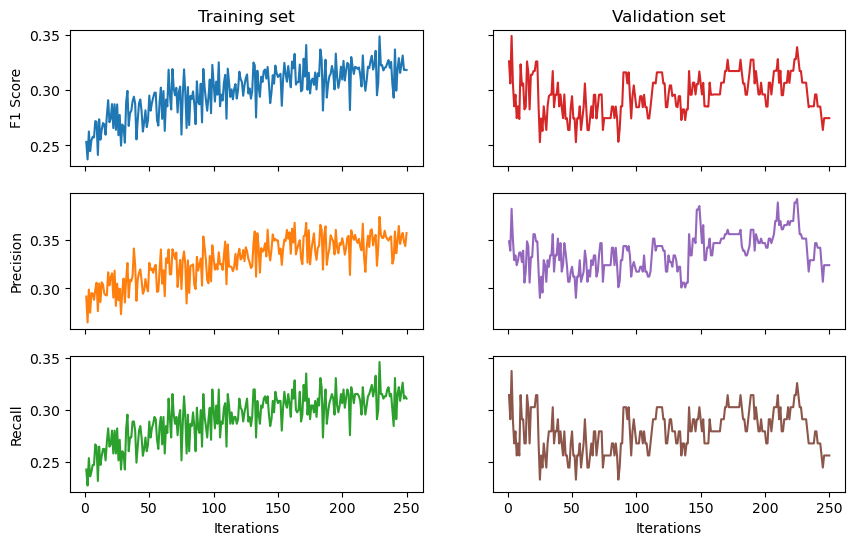

In [39]:
import matplotlib.pyplot as plt
import numpy as np

print("This section is providing inaccurate metrics!")

fig, ((ax_tl, ax_tr), (ax_ml, ax_mr), (ax_bl, ax_br) ) = plt.subplots(3, 2, sharex=True, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Validation set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')

ax_tl.set_ylabel('F1 Score')
ax_ml.set_ylabel('Precision')
ax_bl.set_ylabel('Recall')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)

ax_tl.plot(range_, trainer.train_eval_results['f1'], color=next(colours)) # F1 score
ax_ml.plot(range_, trainer.train_eval_results['precision'], color=next(colours)) # Precision
ax_bl.plot(range_, trainer.train_eval_results['recall'], color=next(colours)) #Recall

ax_tr.plot(range_, trainer.val_eval_results['f1'], color=next(colours)) # F1 score
ax_mr.plot(range_, trainer.val_eval_results['precision'], color=next(colours)) # Precision
ax_br.plot(range_, trainer.val_eval_results['recall'], color=next(colours)) # Recall

## Test Results!

In [40]:
# Calculate metrics
test_acc = accuracy(model(test_final_circuit), np.array(test_labels))
test_f1 = f1(model(test_final_circuit), np.array(test_labels))
test_precision = precision(model(test_final_circuit), np.array(test_labels))
test_recall = recall(model(test_final_circuit), np.array(test_labels))

# Print results neatly formatted as percentages
print("* Test Results *")
print("------------------------------")
print(f"Accuracy: {test_acc * 100:.2f}%")
print(f"F1 Score: {test_f1 * 100:.2f}%")
print(f"Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")
print("------------------------------")

* Test Results *
------------------------------
Accuracy: 53.19%
F1 Score: 28.37%
Precision: 32.25%
Test Recall: 26.60%
------------------------------


## Scratch Paper

EXCERSIZE: sample output

In [ ]:
correct = 0
incorrect = 0

length = len(train_final_circuit)
sample_input = train_final_circuit[0:length]  # Assuming train_final_circuit contains circuits

for index in range(length):
    sample_output = model(sample_input[index:index + 1])
    predicted = np.round(sample_output).astype(int).flatten()
    label = train_labels[index].astype(int)

    print(f"Probability: {sample_output}")
    print(f"Predicted: {predicted} | Label: {label}")

    if np.array_equal(predicted, label):
        print("Correct!")
        correct += 1
    else:
        print("Incorrect")
        incorrect += 1

    print("\n")

print(f"Correct values = {correct}")
print(f"Incorrect values = {incorrect}")
print(f"Total values = ", length)

